# Bonus1: Parallel Algorithms

### Name: [RUI LI]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [110]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [111]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [112]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.02001646 -0.02824883 -0.10657544 -0.06831073  0.04455496  0.04606296
  -0.05966172 -0.0062372 ]]
test std = 
[[1.01894089 1.16665708 1.16418355 1.07395802 1.00658695 0.99331585
  0.90194216 0.98895725]]


## 1.4. Add a dimension of all ones

In [113]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## WORKER

In [114]:

class Worker:
    def __init__(self,x,y, idx):
        self.x = x #  s−by−d l o c a l f e a t u r e ma tr
        self.y = y  # s−by−d l o c a l f e a t u r e ma tr
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of featrues
        self.w = numpy.zeros((self.d,1)) #d by 1 model parameter vector
        self.g = numpy.zeros((self.d,1))
        self.neighbor_weight = {}
        self.link_list = []
        self.idx = idx

    def set_param(self,w):
        self.w = w
        
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s by d matrix
        yxw = numpy.dot(yx, self.w) 
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1 + vec1)
        return numpy.sum(vec2)
    
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) #s by d matrix
        yxw = numpy.dot(yx, self.w) #s by 1
        vec1 = numpy.exp(yxw) #s by 1
        vec2 = numpy.divide(yx, 1 + vec1) #s by d
        #g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) #d by 1
        vec3 = -numpy.mean(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        self.g = vec3 + lam * self.w
        
    def broadcast_weight(self):
        for l in self.link_list:
            self.exchange_weight(l)
            
    def exchange_weight(self, worker):
        if worker.idx not in self.neighbor_weight.keys():
            self.neighbor_weight[worker.idx] = worker.w
        if self.idx not in worker.neighbor_weight.keys():
            worker.exchange_weight(self)
            
    #add each other
    def add_link(self, worker):
        self.link_list.append(worker)
        worker.link_list.append(self)

    def update_weight(self, alpha, weight):
        neighbor_num =len(self.link_list)
        new_w = weight * self.w
        for i in self.neighbor_weight.keys():
            new_w += self.neighbor_weight[i]
        new_w  /= (neighbor_num + weight)
        self.w = new_w - alpha * self.g
        self.neighbor_weight = {}
        return self.w


## INITIALIZATION
        

In [115]:
import math

#create m worker nodes
def create_workers(m, x, y):
    n,d = x.shape
    s = math.floor(n / m)
    workers = []
    for i in range(m):
        indices = list(range(int(i * s), int((i+1)*s)))
        worker = Worker(x[indices, :], y[indices, :], str(i))
        workers.append(worker)
    
    workers[0].add_link(workers[1])
    workers[0].add_link(workers[2])
    workers[1].add_link(workers[2])
    workers[1].add_link(workers[3])
    workers[2].add_link(workers[4])
    workers[3].add_link(workers[4])
    workers[4].add_link(workers[5])
    workers[4].add_link(workers[6])
    workers[5].add_link(workers[6])
    return workers

m = 7

In [116]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [117]:
def test_decetralized_opt(lam, alpha, max_epoch, weight):
    objvals = numpy.zeros(max_epoch) # store the objective values
    W = numpy.zeros((d+1,1))
    for t in range(max_epoch):
        #broadcast
        w = numpy.zeros((d+1,1))
        #worker local computation
        for i in range(m):
            workers[i].gradient()
            workers[i].broadcast_weight()
            w += workers[i].update_weight(alpha, weight)
        w /= m
        obj = objective(w, x_train, y_train, lam) #compute objective function
        print('Objective function value = ' + str(obj))
        objvals[t] = obj
        W=w
    return objvals,W

In [118]:
lam = 1E-6
alpha = 0.4
max_epoch = 100
weight = 1

workers = create_workers(m, x_train, y_train)
objvals_unweighted,w = test_decetralized_opt(lam, alpha, max_epoch, weight)

Objective function value = 0.6463821902095791
Objective function value = 0.6260019814957664
Objective function value = 0.6054851490087807
Objective function value = 0.5887789098107991
Objective function value = 0.5751883794167957
Objective function value = 0.5638107119103439
Objective function value = 0.5540583272061864
Objective function value = 0.5457044018015823
Objective function value = 0.5385009260476686
Objective function value = 0.5321927167493751
Objective function value = 0.5266469461404132
Objective function value = 0.521750063023307
Objective function value = 0.5173899527980214
Objective function value = 0.513490825575034
Objective function value = 0.5099914537256128
Objective function value = 0.506835498883941
Objective function value = 0.5039789774308063
Objective function value = 0.5013858938370814
Objective function value = 0.4990243951181186
Objective function value = 0.4968678277052684
Objective function value = 0.49489374479588016
Objective function value = 0.4930825

In [119]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.215625
Test classification error is 0.21875


In [120]:
lam = 1E-6
alpha = 0.4
max_epoch = 100
weight = 5

workers = create_workers(m, x_train, y_train)
objvals_weighted,w = test_decetralized_opt(lam, alpha, max_epoch, weight)

Objective function value = 0.6463821902095791
Objective function value = 0.6192608181321215
Objective function value = 0.5973911901136598
Objective function value = 0.5801376478458373
Objective function value = 0.5661602735504035
Objective function value = 0.554656878338881
Objective function value = 0.5450516855731242
Objective function value = 0.5369287087349691
Objective function value = 0.529983260716268
Objective function value = 0.5239875081885392
Objective function value = 0.5187681059320016
Objective function value = 0.5141911276693346
Objective function value = 0.5101516035498906
Objective function value = 0.5065661529346396
Objective function value = 0.5033677252976936
Objective function value = 0.5005017900383116
Objective function value = 0.4979235367925455
Objective function value = 0.49559579108518204
Objective function value = 0.49348744325398164
Objective function value = 0.49157225032704777
Objective function value = 0.4898279121722835
Objective function value = 0.4882

In [121]:

# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.2140625
Test classification error is 0.21875


## COMPARE WEIGHTED AND UNWEIGHTED

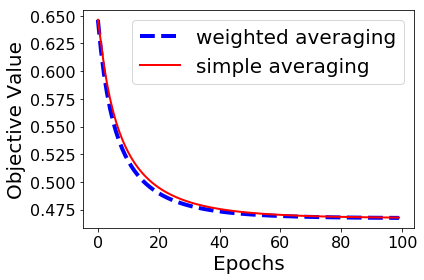

In [122]:
# plot the 2 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_weighted = range(len(objvals_weighted))
epochs_unweighted = range(len(objvals_unweighted))

line0, = plt.plot(epochs_weighted, objvals_weighted, '--b', LineWidth=4)
line1, = plt.plot(epochs_unweighted, objvals_unweighted, '-r', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['weighted averaging', 'simple averaging'], fontsize=20)

plt.tight_layout()
plt.show()
fig.savefig('compare_weight_unweight.pdf', format='pdf', dpi=1200)